# ZOIDBERG2.0
## COMPUTER AIDED DIAGNOSIS
Given some X-ray images, use machine learning to help doctors detecting pneumonia.

<hr>

### Goal 
The goal of this machine learning project is to be able to detect pneumonia infected lughgs based on X-ray images.
The algorithm has to be able to detect 3 different classes : 
1. No pneumonia
2. Viral pneumonia
3. Bacterian pneumonia


### Steps 
1. Data understanding 
2. Dataset pre-processing
3. Dataset statistics 
4. ML pipeline creation
5. ML training / fine nuning / evaluation
6. Visualization 
7. Model saving & repetability 


### Sources / cheatsheet : 
- jupyter notebook MD syntax guide : [click me](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd)

<hr>

## Step 1 - Data understanding

##### Data storage
The dataset is stored loaclly on the computer in ```/Users/xavierschaefer/Documents/Epitech/T-DEV-810/ZOIDBERG/Zoidberg/chest_Xray/```

In this directory, 3 datasets are stored : 
- ```train/``` for training the model 
- ```test/``` for testing the model
- ```val/``` for validation data

For each sub directory, there is a `/PNEUMONIA/` folder and a `/NORMAL/` folder. 
Those folders contain all the X-ray images of infected and non infected lungs according to their parent folder. 

All images are stored in *.jpeg* format

##### Dataset labels 
Images of infected lungs have a "virus" or "bacterian" label inside the name. 
Healthy lungs dont have any sting labels. 

example : `chest_Xray/train/PNEUMONIA/person5_bacteria_15.jpeg`

##### Dataset image example 
<img src="chest_Xray/test/NORMAL/IM-0011-0001.jpeg" alt="Alt Text" height="200">



test 624
train 5217
val 17


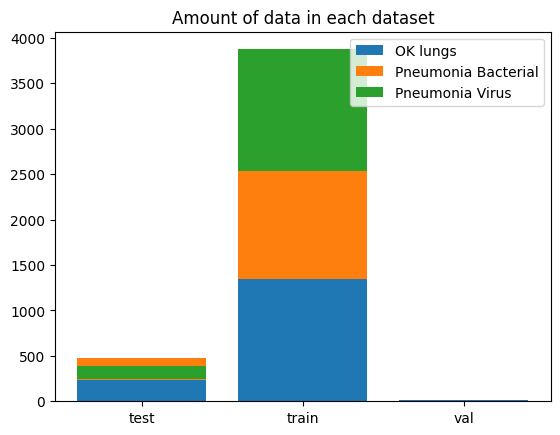

In [2]:
# High level data set statistics 
import os 
import matplotlib.pyplot as plt
root_path = './chest_Xray/'
dir_dict = {}
for dir in os.listdir(root_path):
    if os.path.isdir(root_path+dir) is True:
        dir_dict[dir] = {
            'normal_len': len(os.listdir(f"{root_path+dir}/NORMAL/")),
            'pneu_bact_len': len([i for i in os.listdir(f"{root_path+dir}/PNEUMONIA/") if 'bacteria' in i]),
            'pneu_virus_len': len([i for i in os.listdir(f"{root_path+dir}/PNEUMONIA/") if 'virus' in i])
        }

normal_len = []
pneu_bact_len = []
pneu_virus_len = []

for dir in dir_dict:
    normal_len.append(dir_dict[dir]['normal_len'])
    pneu_bact_len.append(dir_dict[dir]['pneu_bact_len'])
    pneu_virus_len.append(dir_dict[dir]['pneu_virus_len'])
    print(dir, dir_dict[dir]['normal_len']+ dir_dict[dir]['pneu_bact_len']+ dir_dict[dir]['pneu_virus_len'])

fig, ax = plt.subplots()


ax.bar(dir_dict.keys(), normal_len, label= 'OK lungs')
ax.bar(dir_dict.keys(),pneu_bact_len, bottom=normal_len, label= 'Pneumonia Bacterial')
ax.bar(dir_dict.keys(),pneu_virus_len, bottom=pneu_bact_len, label= 'Pneumonia Virus')

ax.set_title("Amount of data in each dataset")
ax.legend(loc="upper right")
plt.show()




The data sets are split like this : 
- `test/` : **624** images
- `train/` : **5217** images
- `val/` : **17** images

<hr>

## Step 2 - Dataset statistics

In this step I will follow the bellow order. 
I will first do all the steps and at the end, make a summary and adjust accordinglly to the results. 
-> This will allow me to have 
- A global overview of my data set to fix the issues optimally 
- Time optimization -> prevent fixing issues to soon and then redo the same exercise 
- Have a clear action plan : 
    - Blocking point for the next step 
    - Optimazable but not blocking 
    - Automatization for traning

1. Number of images per classes
2. Image dimentions
3. Colors repartition / pixel level
4. Image sharpness & noise
5. Similarity between images
6. Check for metadata


### KPI definition
### 1. **Number of images per class**

This analysis will tell us if the dataset is balances between the classes -> unbalances classes = bias to the model
We will display : 
- The % of images for each class
- The % of images for each class in each dataset

-> if the classes are not equally balanced we may want to do data augmentation. 


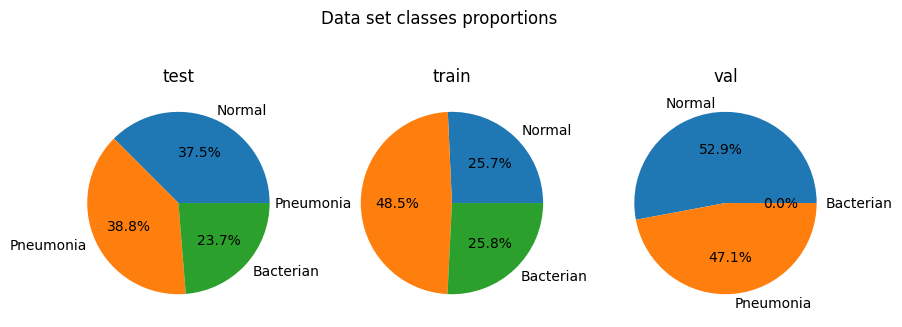

In [3]:


plt.figure(figsize=(10, 4))
subplot_index = 1
for dir in dir_dict:
    total = dir_dict[dir]["normal_len"] + dir_dict[dir]["pneu_bact_len"] + dir_dict[dir]["pneu_virus_len"]
    y = [dir_dict[dir]["normal_len"] , dir_dict[dir]["pneu_bact_len"] , dir_dict[dir]["pneu_virus_len"]]
    labels = ['Normal', "Pneumonia", "Bacterian"]
    plt.subplot(1, 3, subplot_index,)
    plt.pie(y, labels=labels, autopct='%1.1f%%' )
    plt.title(dir)
    subplot_index += 1

plt.suptitle("Data set classes proportions")

plt.show()



**Summary :**
- Test dataset :
    The test dataset is almoste evenlly distribued.
    However the barcterian class has less data than the other classes. Somme wheights may be applied
- Train dataset :
    Uneven distribution between "Normal" class and the others. Wheights or data augmentation have to be applied !
- Validation dataset : 
    ! No bacterian class ! -> must be clarified. Why ?!


**Data distribution strategy**

The main goal is to be able to predict if a person has a pneumonia or not based on the x-ray image. 
The real life distribution between Pneumonia and Normal is that there is faar more normal than Pneumonia. 
However, for machine learning **training** purpose, we need to have a balance between all classes (even if real life might be different)
-> For testing phase we can change the proportion in a second step.




### 2. Images dimentions statistics

Goal of this step is to see the distribution of the images shapes and compare them between the classes and datasets

**KPI's to monitor**

- Number of pixels = height * width
- Image shape (square, landscape, portrait)
- Image ratio = height / width

**Visualization**

-> Historigrams & Boxplots

In [4]:
from PIL import Image
import pandas as pd
import plotly.express as px
from IPython.display import HTML
from plotly.subplots import make_subplots

classes = ['PNEUMONIA','NORMAL',]

#gloabl images repartitions
def collect_image_sizes(image_dir):
    dimensions = []
    shapes = []
    labels = []
    ratio = []
    for cla in classes:
        new_image_dir = f"{image_dir}{cla}/"
        for fname in os.listdir(new_image_dir):
            if fname.endswith(('.jpg', '.png', '.jpeg')):
                img = Image.open(os.path.join(new_image_dir, fname))
                image_size = img.size
                dimensions.append(image_size[0] * image_size[1])  # (width, height)
                if image_size[0] < image_size[1]:
                    shape = "portrait"
                    ratio.append(image_size[1]/image_size[0])
                elif image_size[0] > image_size[1]:
                    shape = "landscape"
                    ratio.append(image_size[0]/image_size[1])
                else: # if width = height
                    shape = "square"
                    ratio.append(1)
                shapes.append(shape)
                labels.append(new_image_dir)


    return dimensions, shapes, labels, ratio

# Exemple pour le dossier train
images_shapes_dict = {
    'total_dimentions': [],
    'total_shapes': [],
    'total_lables':[],
    'total_ratio': []
}

for dir in dir_dict: 
    dimensions, shapes, lables, ratio = collect_image_sizes(f"{root_path}{dir}/")
    images_shapes_dict['total_dimentions'] = images_shapes_dict['total_dimentions'] + dimensions
    images_shapes_dict['total_shapes'] = images_shapes_dict['total_shapes'] + shapes
    images_shapes_dict['total_lables'] = images_shapes_dict['total_lables'] + lables
    images_shapes_dict['total_ratio'] = images_shapes_dict['total_ratio'] + ratio


images_dim_df = pd.DataFrame(images_shapes_dict)

fig1 = px.histogram(images_dim_df, x="total_dimentions", color="total_lables", title="Datasets and Classes image pixels distribution histograms")

HTML(fig1.to_html(include_plotlyjs='cdn')) 

In [5]:
fig2 = px.box(images_dim_df, x="total_lables", y="total_dimentions", color="total_lables",
             points= "all",
             title="Datasets and Classes image pixels distribution box plot",
            )
HTML(fig2.to_html(include_plotlyjs='cdn'))

In [6]:
fig3 = px.box(images_dim_df, x="total_shapes", y="total_ratio", color="total_lables",
             points= "all",
             title="Image ratio ",
            )
HTML(fig3.to_html(include_plotlyjs='cdn'))

**Summary**

- High dispertion in the images resolution (number of pixels) -> resizing needed !
- Ratio dispertion is high as well. 3 options:
    1. resize + padding
    2. resize direct (distortion)
    3. resize with aspect ration + padding (adaptatif)

### 3. Color repartition and Pixel level
Goal of this step is to evaluate the colorimetry of the datasets 
- Dark images
- Contrast
- Check for outliers 

-> Also it is important to check the differences between the classes

**KPI to monitor**

- Average pixel value
- Pixel value standard deviation
- Min/Max pixel values

**Vizualisation**

-> Histograms and boxplots


In [9]:
import numpy as np

def analyze_grayscale_images(image_dir):
    mean = []
    st_dev = []
    max_val = []
    min_val = []
    labels = []
    file_name = []
    for cla in classes:
        new_image_dir = f"{image_dir}{cla}/"
        for fname in os.listdir(new_image_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(os.path.join(new_image_dir, fname)).convert('L')
                pixels = np.array(img).flatten()
                mean.append(np.mean(pixels))
                st_dev.append(np.std(pixels))
                min_val.append(np.min(pixels))
                max_val.append(np.max(pixels))
                labels.append(new_image_dir)
                file_name.append(fname)
    return mean,st_dev,min_val,max_val,labels,file_name

# Exemple pour le dossier train
images_color_dict = {
    'pixel_mean': [],
    'pixel_std': [],
    'pixel_min':[],
    'pixel_max': [],
    'labels': [],
    'fname':[]
}

for dir in dir_dict: 
    mean,st_dev,min_val,max_val,labels,fname = analyze_grayscale_images(f"{root_path}{dir}/")
    images_color_dict['pixel_mean'] = images_color_dict['pixel_mean'] + mean
    images_color_dict['pixel_std'] = images_color_dict['pixel_std'] + st_dev
    images_color_dict['pixel_min'] = images_color_dict['pixel_min'] + min_val
    images_color_dict['pixel_max'] = images_color_dict['pixel_max'] + max_val
    images_color_dict['labels'] = images_color_dict['labels'] + labels
    images_color_dict['fname'] = images_color_dict['fname'] + fname


images_colors_df = pd.DataFrame(images_color_dict)

fig1 = px.histogram(images_colors_df, x="pixel_mean", color="labels", title="Images pixel grey scale mean distribution",hover_data="fname")

HTML(fig1.to_html(include_plotlyjs='cdn'))



In [8]:
fig1 = px.histogram(images_colors_df, x="pixel_std", color="labels", title="Images pixel grey scale standard deviation distribution",hover_data='fname')

HTML(fig1.to_html(include_plotlyjs='cdn'))

In [11]:
#Outliers file names 
print("------Mean------")
for file_name, pix_mean in zip(images_color_dict['fname'],images_color_dict['pixel_mean']):
    if pix_mean < 60 or pix_mean > 200:
        print(file_name, pix_mean)
print("------Standard deviation------")
for file_name, pix_std in zip(images_color_dict['fname'],images_color_dict['pixel_std']):
    if pix_std < 25 or pix_std > 85:
        print(file_name, pix_std)


------Mean------
person14_virus_44.jpeg 58.722965970594316
person1413_bacteria_3615.jpeg 221.53662337662337
person1405_bacteria_3564.jpeg 201.83890572075836
------Standard deviation------
person924_virus_1581.jpeg 85.72230586358619
person1413_bacteria_3615.jpeg 20.415354379549004
person1303_bacteria_3267.jpeg 23.36129794814134
person636_bacteria_2527.jpeg 20.959803711746904
person1405_bacteria_3564.jpeg 23.327445570075
person108_virus_199.jpeg 24.263984082993296
person1944_bacteria_4869.jpeg 86.39653060053313
person162_virus_320.jpeg 87.48042281689389



**Summary**

- Mean histogram : 
    High spread and some outliers. see images above. 
    Low brightness images :

    <img src="chest_Xray/test/PNEUMONIA/person14_virus_44.jpeg" alt="Mean histogram" width="400"/>

    High brightness images :

    <img src="chest_Xray/train/PNEUMONIA/person1413_bacteria_3615.jpeg" alt="Mean histogram" width="400"/>


- Standard deviation histogram : 
    Here the standard deviation is an image of the contrast.
    
    Distribution is not even between classes : for example "./train/NORMAL" class has a higher contrast than other classes. This will lead to a bias during training.</br>
    Maybe this is an important feature to predict if patient is Normal or infected.</br>
    To train the model it can be interseting to test with and without standardisation of the contrast and monitor the performances</br>
    High standard deviation on pixel level :
    
    <img src="chest_Xray/train/PNEUMONIA/person162_virus_320.jpeg" alt="std distogram" width="400"/>

### 4. Image sharpness and Noise
Goal of this step determine whitch images are unusable of have to be corected. 
- Blurry images
- Noisy images

-> Also it is important to check the differences between the classes

**KPI to monitor**

- **Variance of Laplacian** calculation : image filter that allows to detect change of intencity. Used to evaluate the sharpness of an image</br>
    Low value -> Blurry image</br>
    High value -> Sharp image</br>
- **Sobel edges mean** : Detect image contours. We calculate the mean value of all contours inside the image </br>
    Low value -> Blurry image</br>
    High value -> Sharp image</br>
- **PSNR** (Peak Signal-to-Noise Ratio) : Comparaison of 2 same images, one original and one after compression to detect noise.</br>
    High PSNR (> 30 dB) = low noise</br>
    low PSNR (< 20 dB) = high noise</br>

**Vizualisation**

-> Histograms and boxplots

In [14]:
import cv2


def sharpness(image_path):
    sobel_list = []
    laplacien_list = []
    labels = []
    file_name = []
    
    for cla in classes:
        new_image_dir = f"{image_path}{cla}/"
        for fname in os.listdir(new_image_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(new_image_dir+fname, cv2.IMREAD_GRAYSCALE)
                laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
                sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
                sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
                sobel = np.hypot(sobelx, sobely) 

                sobel_list.append(sobel.mean())
                laplacien_list.append(laplacian_var)
                labels.append(new_image_dir)
                file_name.append(fname)
    return sobel_list, laplacien_list, labels, file_name


blurry_dict = {
    'laplacian': [],
    'sobel_edges': [],
    'labels': [],
    'fname':[]
}

for dir in dir_dict: 
    sobel, laplacian,labels,fname = sharpness(f"{root_path}{dir}/")
    blurry_dict['sobel_edges'] = blurry_dict['sobel_edges'] + sobel
    blurry_dict['laplacian'] = blurry_dict['laplacian'] + laplacian
    blurry_dict['labels'] = blurry_dict['labels'] + labels
    blurry_dict['fname'] = blurry_dict['fname'] + fname

blurry_df = pd.DataFrame(blurry_dict)

print(blurry_df.head())

    laplacian  sobel_edges                        labels  \
0  104.061749    17.945191  ./chest_Xray/test/PNEUMONIA/   
1  112.330157    15.791221  ./chest_Xray/test/PNEUMONIA/   
2  136.658153    20.650544  ./chest_Xray/test/PNEUMONIA/   
3  126.315252    15.125785  ./chest_Xray/test/PNEUMONIA/   
4  123.546883    16.286553  ./chest_Xray/test/PNEUMONIA/   

                         fname  
0  person147_bacteria_706.jpeg  
1  person100_bacteria_482.jpeg  
2   person78_bacteria_382.jpeg  
3  person124_bacteria_589.jpeg  
4   person1647_virus_2848.jpeg  


In [15]:
# plots
fig1 = px.histogram(blurry_dict, x="laplacian", color="labels", title="Images sharpness Lapacian (variance) filter")

HTML(fig1.to_html(include_plotlyjs='cdn'))

In [16]:
# plots
fig1 = px.histogram(blurry_dict, x="sobel_edges", color="labels", title="Images sharpness sobel_edges (mean) ")

HTML(fig1.to_html(include_plotlyjs='cdn'))

In [18]:
#Outliers file names 
print("------Laplacian------")
for file_name, laplacian in zip(blurry_dict['fname'],blurry_dict['laplacian']):
    if laplacian < 10 or laplacian > 2200:
        print(file_name, laplacian)
print("------Sobel edges------")
for file_name, sobel_edges in zip(blurry_dict['fname'],blurry_dict['sobel_edges']):
    if sobel_edges < 10 or sobel_edges > 60:
        print(file_name, sobel_edges)

------Laplacian------
person1368_virus_2354.jpeg 2284.870265772358
person1167_bacteria_3113.jpeg 9.82317263834651
person803_bacteria_2710.jpeg 8.852724686612532
person14_bacteria_51.jpeg 9.147754632772092
person592_bacteria_2434.jpeg 8.124156021768865
person1530_virus_2664.jpeg 2505.9830384109405
person379_bacteria_1721.jpeg 9.668506573062075
------Sobel edges------
NORMAL2-IM-0081-0001.jpeg 9.375778622763765
NORMAL2-IM-0105-0001.jpeg 9.855903434991612
NORMAL2-IM-0073-0001.jpeg 9.681921796329936
person1178_bacteria_3126.jpeg 9.519758811573757
person1200_virus_2042.jpeg 9.456917076527361
person1590_bacteria_4175.jpeg 9.113968447314303
person108_virus_201.jpeg 9.465010711709798
person1866_bacteria_4740.jpeg 8.408049006034446
person1872_bacteria_4750.jpeg 7.02981206967009
person1530_virus_2664.jpeg 62.27464918609185
person21_bacteria_72.jpeg 8.502984343769816
person453_virus_935.jpeg 9.714892012840439
person108_virus_199.jpeg 5.6729801663552495
person272_virus_559.jpeg 9.138397885469384
p

**Summary**

- Laplacian Variance :</br>
    High laplacian variance value (sharp): </br>
    <img src="chest_Xray/train/PNEUMONIA/person1530_virus_2664.jpeg" alt="laplacian high" width="400"/>

    Low laplacian variance value (blurry): </br>
    <img src="chest_Xray/train/PNEUMONIA/person592_bacteria_2434.jpeg" alt="laplacian low" width="400"/>

- Sobel edges mean : </br>
    High sobel mean value (sharp): </br>
    <img src="chest_Xray/train/PNEUMONIA/person1530_virus_2664.jpeg" alt="sobel high" width="400"/>

    Low sobel mean value (blurry): </br>
    <img src="chest_Xray/test/NORMAL/NORMAL2-IM-0081-0001.jpeg" alt="sobel low" width="400"/>


### 5. Similarity between images
Goal of this step is to see if there is similarity between images in the dataset  
- Duplicated images
- Too many images that are almost the same

-> This is important so that we dont feed too similar images to the model. This is no added value (overfiting)

**KPI to monitor**

- **pHash** (Perceptual hash) : creates a hash of each image and then compares the hash. This is a fast process. However it will only detect duplicates or very close images 

**Vizualisation**

-> Histograms and boxplots

1. Number of images per classes
2. Image dimentions
3. Colors repartition / pixel level
4. Image sharpness & noise
5. Similarity between images
6. Check for metadata

##### Calculation methodology
##### KPI results